In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
# from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/all')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [7]:
S_PREFIX = '25-resnet2'

In [8]:
from torchvision.datasets.folder import pil_loader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TTF

### Create dataloader

In [9]:
class MatchedFilesDataset(Dataset):
    def __init__(self, fnames, y, tfms, path):
        self.path,self.fnames = path,fnames
        self.open_fn = pil_loader
        self.y=y
        self.open_y_fn = pil_loader
        assert(len(fnames)==len(y))
        
        self.n = self.get_n()
        self.c = self.get_c()
        self.tfms = tfms
#         self.sz = self.get_sz()
        
#     def get_sz(self): return self.transform.sz
    def get_x(self, i): return self.open_fn(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): return self.open_y_fn(os.path.join(self.path, self.y[i]))
    def get_n(self): return len(self.fnames)
    def get_c(self): return 2
    
    def get(self, tfms, x, y):
        for fn in tfms:
            #pdb.set_trace()
            x, y = fn(x, y)
        return (x, y)
    
    def __getitem__(self, idx):
        x,y = self.get_x(idx),self.get_y(idx)
        return self.get(self.tfms, x, y)
    
    def __len__(self): return self.n

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

In [10]:

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [11]:
def crop_bg_pil(x,y):
    w, h = x.size
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    pad_right=32-w%32
    return TTF.crop(x, top, 0, bot-top, w+pad_right), TTF.crop(y, top, 0, bot-top, w+pad_right)

In [12]:
class RHF(object):
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x, y):
        if random.random() < self.p:
            return TTF.hflip(x), TTF.hflip(y)
        return x,y

In [13]:
class RR(object):
    def __init__(self, degrees=2): self.degrees = degrees
    def __call__(self, x, y):
        angle = random.uniform(-self.degrees, self.degrees)
        return TTF.rotate(x, angle), TTF.rotate(y, angle)

In [14]:
def tfm_x_wrapper(tfm):
    return lambda x,y: (tfm(x), y)

In [15]:
class RRC(transforms.RandomResizedCrop):
    def __call__(self, x, y):
        i, j, h, w = self.get_params(x, self.scale, self.ratio)
        x = TTF.resized_crop(x, i, j, h, w, self.size, self.interpolation)
        y = TTF.resized_crop(y, i, j, h, w, self.size, self.interpolation)
        return x, y

In [16]:
class RC():
    def __init__(self, targ_sz):
        self.targ_sz = targ_sz

    def __call__(self, x, y):
        rand_w = random.uniform(0, 1)
        rand_h = random.uniform(0, 1)
        w,h = x.size
        t_w,t_h = self.targ_sz
        start_x = np.floor(rand_w*(w-t_w)).astype(int)
        start_y = np.floor(rand_h*(h-t_h)).astype(int)
        return TTF.crop(x, start_y, start_x, t_h, t_w), TTF.crop(y, start_y, start_x, t_h, t_w)

In [17]:
x_names_val = np.array(glob(str(PATH/'AnswersRGB'/'*.png')))
y_names_val = np.array(glob(str(PATH/'AnswersSeg'/'*.png')))

In [18]:
def convert_y(y_img):
    y_new = np.zeros(y_img.shape, dtype=int)
    y_new[y_img==VEHICLES] = 1
    cutoff_y = int(y_new.shape[0]*.83)
    y_new[cutoff_y:,:] = 0

    y_new[y_img==ROADS] = 2
    y_new[y_img==ROAD_LINES] = 2
    return torch.from_numpy(y_new).long()

def xy_tensor(x,y):
    y_img = np.array(y, np.int32, copy=False)
    return TTF.to_tensor(x), convert_y(y_img[:,:,0])

In [19]:
def torch_loader(f_ext, data_path, bs, size, workers=7, random_crop=False):
    # Data loading code
    x_names = np.sort(np.array(glob(str(data_path/f'CameraRGB{f_ext}'/'*.png'))))
    y_names = np.sort(np.array(glob(str(data_path/f'CameraSeg{f_ext}'/'*.png'))))
#     x_names_val = np.array(glob(str(data_path/f'AnswersRGB{f_ext}'/'*.png')))
#     y_names_val = np.array(glob(str(data_path/f'AnswersSeg{f_ext}'/'*.png')))

    x_n = x_names.shape[0]
    val_idxs = list(range(x_n-300, x_n))
#     val_idxs = list(range(300))
#     val_x,val_y = x_names_val, y_names_val
#     trn_x,trn_y = x_names, y_names
    ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    normalize = transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])
    
    train_tfms = [
        crop_bg_pil,
        tfm_x_wrapper(transforms.ColorJitter(.2,.2,.2)),
#         tfm_x_wrapper(Lighting(0.1, __imagenet_pca['eigval'], __imagenet_pca['eigvec'])),
        RR(),
        RHF(),
#         RC((size,size)),
        xy_tensor,
        tfm_x_wrapper(normalize),
    ]
    if random_crop:
        train_tfms.insert(3,RRC(size, scale=(0.4, 1.0)))
    train_dataset = MatchedFilesDataset(trn_x, trn_y, train_tfms, path='')
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_tfms = [
        crop_bg_pil,
        xy_tensor,
        tfm_x_wrapper(normalize)
    ]
    val_dataset = MatchedFilesDataset(val_x, val_y, val_tfms, path='')
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data


In [20]:
def denorm(x):
    x_np = x.cpu().numpy()
    x_np = np.rollaxis(x_np, 0, 3)
    mean=np.array([0.4914 , 0.48216, 0.44653])
    std=np.array([0.24703, 0.24349, 0.26159])
    x_np = x_np*std+mean
    return x_np

In [21]:
sz = 96
bs = 2
data = torch_loader('-150', PATH, bs, sz)

In [22]:
x,y = data.trn_ds[0]

In [23]:
x.shape, y.float().mean()

(torch.Size([3, 96, 224]), 0.5408761160714286)

In [24]:
x_out = denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


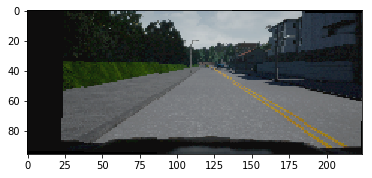

In [25]:
plt.imshow(x_out)

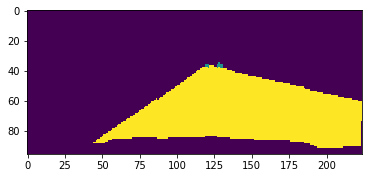

In [26]:
plt.imshow(y)

In [27]:
def new_acc(preds, targs):
    mx,idx = torch.max(preds, 1)
    return (idx == targs).float().mean()
def dice_mult(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## U-net (ish)

In [28]:
from torchvision.models import vgg11_bn

In [29]:
def vgg11(pre): return children(vgg11_bn(pre))[0]

In [30]:
model_meta = {
    resnet18:[8,6], resnet34:[8,6], resnet50:[8,6], resnet101:[8,6], resnet152:[8,6],
    vgg11:[0,13], vgg16:[0,22], vgg19:[0,22],
    resnext50:[8,6], resnext101:[8,6], resnext101_64:[8,6],
    wrn:[8,6], inceptionresnet_2:[-2,9], inception_4:[-1,9],
    dn121:[0,7], dn161:[0,7], dn169:[0,7], dn201:[0,7],
}

In [31]:
def get_base(f):
    cut,lr_cut = model_meta[f]
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers), lr_cut

In [32]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [33]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
#         N,C,H,W = x_p.size()
#         up_p = F.upsample(x_p, size=(H,W),mode='bilinear')
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [34]:
class Unet34(nn.Module):
    def __init__(self, f=resnet34):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,32,16)
        self.up6 = nn.ConvTranspose2d(16, 3, 1)
        self.x_skip = nn.Sequential(
            nn.Conv2d(3,32,1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
    def forward(self,x):
        x_skip = self.x_skip(x)
        x = F.relu(self.rn(x), inplace=True)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, x_skip)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [38]:
m = Unet34().cuda()
ext = '-150'
sz = 96
bs = 256
md = torch_loader('-150', PATH, bs, sz, random_crop=True)
x,y = next(iter(md.trn_dl))

m(VV(x)).shape

torch.Size([256, 3, 96, 96])

In [39]:
class Unet11(nn.Module):
    def __init__(self, f=vgg11):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[0][i]) for i in [2,6,13,20,27]]
        self.up0 = UnetBlock(512,512,256)
        self.up1 = UnetBlock(256,512,256)
        self.up2 = UnetBlock(256,256,256)
        self.up3 = UnetBlock(256,128,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5  = nn.Conv2d(256,3,1)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up0(x, self.sfs[4].features)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x

In [40]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        if isinstance(self.model, FP16):
            model = self.model.module
        else:
            model = self.model
        lgs = list(split_by_idxs(children(model.rn), [model.lr_cut]))
#         print('LGS:', lgs)
#         print('Add:', children(model)[1:])
        return lgs + [children(model)[1:]]

In [41]:
def get_learner(md, m_fn=Unet34):
#     m = to_gpu(Unet34())
    m = to_gpu(m_fn())
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    class_weights = torch.FloatTensor([1,6,2]).cuda()
    learn.crit=nn.CrossEntropyLoss(weight=class_weights)
#     learn.crit=nn.CrossEntropyLoss()
#     learn.crit=FocalLoss(2)
#     learn.crit = nn.BCEWithLogitsLoss()
    learn.metrics=[new_acc]
    return learn

### Loading from train6 model

In [42]:
ext = '-150'
sz = 96
bs = 256
md = torch_loader('-150', PATH, bs, sz, random_crop=True)

In [49]:
learn = get_learner(md)

In [50]:
learn.freeze_to(1)

In [51]:
# learn.load('600urn-18-resnet')

epoch      trn_loss   val_loss   new_acc                   
    0      2.63741    3687434132494745.5 0.061824  



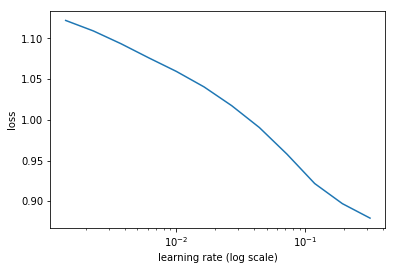

In [53]:
learn.lr_find()
learn.sched.plot()

In [52]:
# lr=1e-1
lr=1e-1
# lr=4e-3
wd=1e-5

lrs = np.array([lr/200,lr/20,lr])/2

In [53]:
# learn.fit(lr,1,wds=wd,cycle_len=15,use_clr=(5,8))
learn.fit(lr,1,wds=wd,cycle_len=30,use_clr_beta=(20,20,.95,.85))

epoch      trn_loss   val_loss   new_acc                   
    0      0.489191   0.247701   0.955937  
    1      0.275755   0.193824   0.954919                  
    2      0.19947    0.055862   0.986965                  
    3      0.161712   0.066944   0.983929                  
    4      0.142368   0.064295   0.97812                   
    5      0.131533   0.135981   0.966517                  
    6      0.129267   0.121059   0.984605                  
    7      0.124572   0.076577   0.98261                   
    8      0.123356   0.446112   0.809212                  
    9      0.123643   0.094599   0.971087                  
    10     0.125525   0.194101   0.969676                  
    11     0.125945   0.110943   0.971003                  
    12     0.152946   0.144819   0.955106                  
    13     0.146907   0.209607   0.944727                  
    14     0.139006   0.120236   0.984572                  
    15     0.133967   0.09108    0.985299               

[array([0.03388]), 0.9917646129926045]

In [54]:
learn.save(f'128urn-{S_PREFIX}-tmp')

In [69]:
learn.load(f'128urn-{S_PREFIX}-tmp')

In [55]:
learn.unfreeze()
learn.bn_freeze(True)

In [56]:
# lr=1e-1
lr=1e-2
# lr=4e-3
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [57]:
learn.fit(lrs, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc                    
    0      0.091947   0.034902   0.991201  
    1      0.099715   0.036235   0.992002                   
    2      0.095021   0.034168   0.992381                   
    3      0.0923     0.033957   0.992137                   
    4      0.091158   0.03332    0.991858                   
    5      0.090402   0.032512   0.991925                   
    6      0.08935    0.0318     0.992363                   
    7      0.088255   0.031643   0.992329                   
    8      0.087648   0.031488   0.992697                   
    9      0.087463   0.030973   0.992483                   


[array([0.03097]), 0.9924826407432557]

In [58]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc                    
    0      0.086673   0.031888   0.992622  
    1      0.087314   0.031093   0.992536                   
    2      0.08695    0.031001   0.99259                    
    3      0.086855   0.030321   0.992732                   
    4      0.086711   0.030314   0.993035                   
    5      0.086903   0.030067   0.993338                   
    6      0.086026   0.029491   0.993166                   
    7      0.085462   0.029836   0.993238                   
    8      0.084907   0.0292     0.993167                   
    9      0.084737   0.02957    0.993178                   


[array([0.02957]), 0.9931784788767497]

In [59]:
learn.save(f'128urn-{S_PREFIX}-0')

In [60]:
learn.load(f'128urn-{S_PREFIX}-0')

In [61]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [62]:
py = np.argmax(py,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


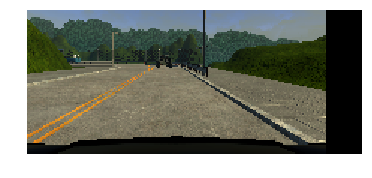

In [63]:
show_img(denorm(x[0]))

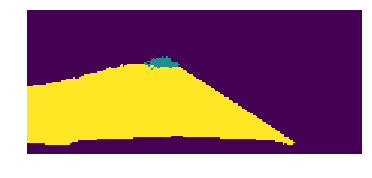

In [64]:
show_img(py[0]);

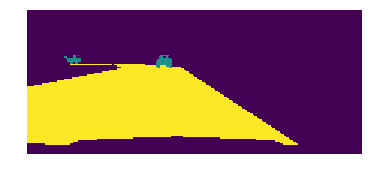

In [65]:
show_img(y[0]);

## 256x256

In [66]:
ext = '-300'
sz=192
bs=32
md = torch_loader(ext, PATH, bs, sz)

In [73]:
lr=3e-2
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [68]:
import gc
gc.collect()

4339

In [69]:
learn = get_learner(md)

In [70]:
learn.freeze_to(1)

In [71]:
learn.load(f'128urn-{S_PREFIX}-0')

 84%|████████▍ | 184/219 [00:31<00:06,  5.81it/s, loss=0.573] 

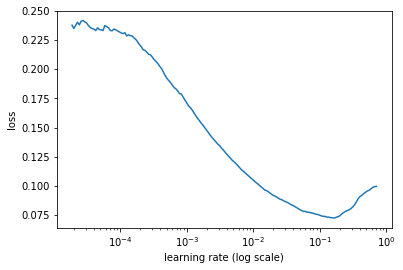

In [72]:
learn.lr_find()
learn.sched.plot()

In [86]:
learn.load(f'128urn-{S_PREFIX}-0')

In [74]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

epoch      trn_loss   val_loss   new_acc                      
    0      0.040306   0.087805   0.990495  
    1      0.032988   0.032281   0.988743                     
    2      0.03098    0.020613   0.991648                     
    3      0.031835   0.022059   0.993513                     
    4      0.026747   0.019587   0.993476                     
    5      0.024452   0.018596   0.993051                     
    6      0.024829   0.016062   0.995235                     
    7      0.024582   0.016546   0.994497                     
    8      0.020348   0.013178   0.995076                     
    9      0.018996   0.011981   0.996208                     


[array([0.01198]), 0.9962080550193787]

In [75]:
learn.save(f'256urn-{S_PREFIX}-tmp')

In [78]:
learn.unfreeze()
learn.bn_freeze(True)

In [77]:
learn.load(f'256urn-{S_PREFIX}-tmp')

In [79]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc                      
    0      0.017673   0.011287   0.996226  
    1      0.017207   0.010712   0.996679                     
    2      0.016921   0.010012   0.996434                     
    3      0.016224   0.010017   0.99654                      
    4      0.016131   0.009674   0.996677                     
    5      0.016192   0.009478   0.996726                     
    6      0.01529    0.009346   0.996823                     
    7      0.01471    0.009229   0.996821                     


[array([0.00923]), 0.996821494102478]

In [ ]:
ext = '-300'
sz=192
bs=32
md = torch_loader(ext, PATH, bs, sz, random_crop=False)
learn = get_learner(md)
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

In [80]:
learn.save(f'256urn-{S_PREFIX}')

In [ ]:
learn.load(f'256urn-{S_PREFIX}')

In [ ]:
x,y = next(iter(md.trn_dl))

In [ ]:
x.shape

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
py = np.argmax(py,1)

In [ ]:
plt.imshow(denorm(x[-1]))

In [ ]:
show_img(py[-1]);

In [ ]:
py[-1].shape

In [ ]:
y[-1].shape

In [ ]:
show_img(y[-1]);

## 512x512

In [81]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

In [82]:
ext = ''
sz=384
bs=16
md = torch_loader(ext, PATH, bs, sz)

In [83]:
learn = get_learner(md)

In [84]:
learn.load(f'256urn-{S_PREFIX}')

 81%|████████  | 352/437 [01:40<00:24,  3.49it/s, loss=0.165] 

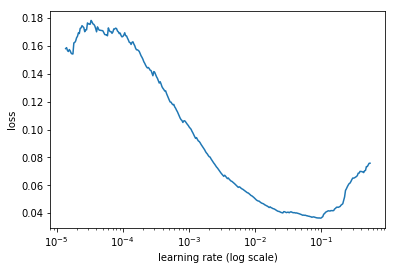

In [85]:
learn.lr_find()
learn.sched.plot()

In [ ]:
learn.load(f'256urn-{S_PREFIX}')

In [ ]:
learn.freeze_to(1)

In [86]:
lr=1e-2
wd=5e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [87]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(5,4))

epoch      trn_loss   val_loss   new_acc                      
    0      0.027179   0.015239   0.996081  
    1      0.025686   0.01684    0.993606                     
    2      0.021532   0.012288   0.996028                     
    3      0.020442   0.011752   0.996229                     


[array([0.01175]), 0.9962290358543396]

In [ ]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(5,4))

In [88]:
learn.save(f'600urn-{S_PREFIX}-tmp')

In [ ]:
learn.load(f'600urn-{S_PREFIX}-tmp')

In [89]:
learn.unfreeze()
learn.bn_freeze(True)

In [90]:
lrs = np.array([lr/200,lr/30,lr])

In [91]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc                      
    0      0.017796   0.01284    0.995639  
    1      0.017484   0.010724   0.996493                     
    2      0.016305   0.010473   0.996414                     
    3      0.016175   0.010093   0.996594                     


[array([0.01009]), 0.9965938051541646]

In [92]:
learn.save(f'600urn-{S_PREFIX}')

In [93]:
ext = ''
sz=384
bs=16
md = torch_loader(ext, PATH, bs, sz, random_crop=False)
learn = get_learner(md)
learn.unfreeze()
learn.bn_freeze(True)

In [94]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(10,4))

epoch      trn_loss   val_loss   new_acc                      
    0      0.091914   0.046233   0.986283  
    1      0.028229   0.019722   0.992398                     
    2      0.024196   0.017305   0.993113                     
    3      0.021517   0.014125   0.994848                     


[array([0.01412]), 0.9948480081558227]

In [95]:
learn.save(f'600urn-{S_PREFIX}-last')

In [96]:
learn.fit(lrs/10,1, wds=wd,cycle_len=5,use_clr=(10,2))

epoch      trn_loss   val_loss   new_acc                      
    0      0.021886   0.013598   0.995627  
    1      0.021839   0.014059   0.995369                     
    2      0.019214   0.01157    0.995651                     
    3      0.015047   0.009466   0.996399                     
    4      0.014573   0.009071   0.996543                     


[array([0.00907]), 0.996543451944987]

In [97]:
learn.save(f'600urn-{S_PREFIX}-last2')

In [98]:
learn.fit(lrs/200,1, wds=wd,cycle_len=5,use_clr=(10,2))

epoch      trn_loss   val_loss   new_acc                      
    0      0.014183   0.008873   0.9967    
    1      0.01376    0.008768   0.996839                     
    2      0.013719   0.008597   0.996904                     
    3      0.013485   0.008511   0.996875                     
    4      0.01319    0.008472   0.996857                     


[array([0.00847]), 0.9968574706713359]

In [99]:
learn.save(f'600urn-{S_PREFIX}-last3')

In [ ]:
ext = ''
sz=288
bs=16
md = torch_loader(ext, PATH, bs, sz, random_crop=False)

In [ ]:
learn = get_learner(md)

In [ ]:
# learn.load(f'600urn-{S_PREFIX}-full')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.save(f'600urn-{S_PREFIX}-full')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
py = np.argmax(py,1)

In [ ]:
plt.imshow(denorm(x[10]))

In [ ]:
show_img(py[10]);

In [ ]:
py[-1].shape

In [ ]:
y[-1].shape

In [ ]:
show_img(y[10]);

## Save results

In [ ]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))

In [ ]:
# model_summary(m, [3,608,800])

In [ ]:
# learn.load('1024urn')
load_model(m, str(PATH/f'models/600urn-{S_PREFIX}.h5'))

In [ ]:
# file = sys.argv[-1]
file = 'test_video.mp4'

if file == 'demo.py':
    print("Error loading video")
    quit

# Define encoder function
def encode(array):
    pil_img = Image.fromarray(array)
    buff = BytesIO()
    pil_img.save(buff, format="PNG")
    return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)

In [ ]:
# resized_video = np.array([scipy.misc.imresize(f, size=(512,512)) for f in video])

In [ ]:
def normalize(x):
    if np.mean(x) > 1:
        x = x/255
    m,s = imagenet_stats
    x = (x-m)/s
    return x
def preprocess(video):
    f1_norm = normalize(video)
    f1_roll = np.rollaxis(f1_norm, 3, 1)
    f1_pad = np.pad(f1_roll, [(0,0),(0,0),(0,8),(0,0)], mode='constant')
    return f1_pad

In [ ]:
f1 = preprocess(video)

In [ ]:
results = []
for i in range(0,f1.shape[0],8):
    xv = VV(torch.from_numpy(f1[i:i+8]).contiguous().float())
    preds = m(xv)
    mx,idx = torch.max(preds, 1)
    idx_slice = idx[:,:-8,:]
    results.append(idx_slice)

In [ ]:
r_stacked = torch.cat(results,0)
r_np = r_stacked.data.cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(video[index])
    ax2.imshow(r_np[index])

In [ ]:
plot_res(10)

In [ ]:
answer_key = {}

# Frame numbering starts at 1
frame_idx = 1
for frame in r_np:
    # Look for red cars :)
    binary_car_result = (frame==1).astype('uint8')
#     print(np.mean(binary_car_result))
    
    # Look for road :)
    binary_road_result = (frame==2).astype('uint8')

    answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
    
    # Increment frame
    frame_idx+=1

# Print output in proper json format
tester_data = json.dumps(answer_key)
with open('tester_data_multi_take2', 'w') as f:
    f.write(tester_data)
print(json.dumps(answer_key))

### Decoding car

In [ ]:
PATH

In [ ]:
from scipy import misc
def decode(packet):
	img = base64.b64decode(packet)
	filename = PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open('results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

In [ ]:
def plot_ans(index):
    ans = decode(ans_data[str(index)][0])
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(r_np[index])
    ax1.set_title('Mine', fontsize=35)
    ax2.imshow(ans)
    ax2.set_title('Answer', fontsize=35)
    ax3.imshow(video[index])
    ax2.set_title('Original', fontsize=35)

In [ ]:
plot_ans(10)

In [ ]:
ans = decode(ans_data['1'][0])

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()